<a href="https://colab.research.google.com/github/dimakpa/DL_Projects/blob/main/FinFineTuningModelImgAndAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pathlib import Path

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame(pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/data/classes.xlsx"))

df.head()

,№,"Узел ЩЖ, TIRADS"
0,178,4
1,179,5
2,180,3
3,181,5
4,182,3


#Обучение модели

In [ ]:
import torch
from torchvision.models import efficientnet_b6 as efficientnet_b6
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import imgaug as ia
from imgaug import augmenters as iaa
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import random
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from statistics import mean
from torch.optim import lr_scheduler

In [ ]:
print(ia.__version__)

0.4.0


In [ ]:
from time import time
from tqdm import tqdm

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/data/study_data_and_aug_study/train/'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/data/study_data_and_aug_study/valid/'

In [ ]:
class DatasetRAM(Dataset):

    def __init__(self, path=None, transform=None, data=None, classes=None):
        super().__init__()
        self.path = path
        self.transform = transform
        self.data = []
        self.class_name_to_idx = {}
        self.idx_to_class_name = []
        if (data != None):
            self.data = data
            for i in range(classes):
                self.class_name_to_idx[i] = i
                self.idx_to_class_name.append(i)
            return
        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)
            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                im = Image.open(image_path)
                im = im.convert(mode='L')
                img = np.array(im)
                self.data.append((img, class_name))

    def __getitem__(self, idx):
        image, class_name = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
      [
          iaa.Fliplr(0.5),
          iaa.Flipud(0.5),
          sometimes(iaa.Crop(percent=(0, 0.1))),
          sometimes(iaa.Affine(
              scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
              translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
              rotate=(-45, 45),
              shear=(-16, 16),
              order=[0, 1],
              cval=(0, 255),
              mode=ia.ALL,
          )),

          iaa.SomeOf((0, 5),
          [
              iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25)),

              iaa.contrast.LinearContrast((0.75, 1.25), per_channel=0.5),
              iaa.OneOf([
                  iaa.GaussianBlur((0, 3.0)),
                  iaa.AverageBlur(k=(2, 7)),
                  iaa.MedianBlur(k=(3, 11)),
              ]),
              iaa.AdditiveGaussianNoise(
                  loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5
              ),
              iaa.OneOf([
                  iaa.Dropout((0.01, 0.1), per_channel=0.5),
                  iaa.CoarseDropout(
                      (0.03, 0.15), size_percent=(0.02, 0.05),
                      per_channel=0.2
                  ),
              ]),
              sometimes(
                  iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
              ),
              # sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
          ],
          random_order=True
          )
      ],
      random_order=True
  )

seq_resize = iaa.Sequential([iaa.Resize({"height": 224, "width": 224})])

In [ ]:
train_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Resize({"height": 224, "width": 224})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.24), (0.12))
])

test_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Resize({"height": 224, "width": 224})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.24), (0.12))
])

In [ ]:
train_dataset = DatasetRAM(path=TRAIN_DATASET_PATH, transform=train_transform)
test_dataset = DatasetRAM(path=TEST_DATASET_PATH, transform=test_transform)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

4102
1090


Image shape: torch.Size([1, 224, 224])
Class idx: 0
Class name: tirads2-3


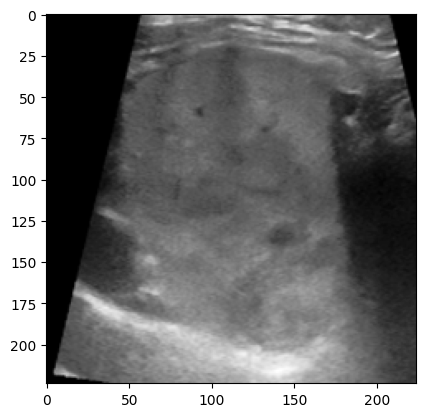

In [ ]:
image, class_idx = train_dataset[0]

print('Image shape:', image.shape)
print('Class idx:', class_idx)
print('Class name:', train_dataset.idx_to_class_name[class_idx])

plt.imshow(image[0], cmap='Greys_r')

Image shape: torch.Size([1, 224, 224])
Class idx: 0
Class name: tirads2-3


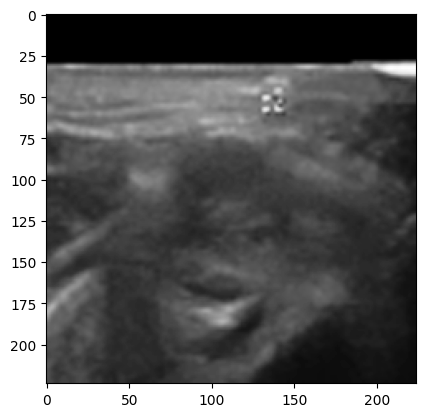

In [ ]:
image, class_idx = test_dataset[100]

print('Image shape:', image.shape)
print('Class idx:', class_idx)
print('Class name:', train_dataset.idx_to_class_name[class_idx])

plt.imshow(image[0], cmap='Greys_r')

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    drop_last=False
)

In [ ]:
for batch in test_dataloader:
    break

In [ ]:
image_batch, class_idx_batch = batch

print('Image batch size:', image_batch.shape)
print('Class index batch size:', class_idx_batch.shape)

Image batch size: torch.Size([8, 1, 224, 224])
Class index batch size: torch.Size([8])


Загружаем модель

In [ ]:
model = efficientnet_b6(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B6_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B6_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth
100%|██████████| 165M/165M [00:01<00:00, 167MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Заменим входной слой и выходной с определенными весами


`torch.nn.init.xavier_normal_(model.classifier[1].weight)`

 Это строка кода инициализирует веса для определенного слоя модели с помощью метода инициализации Xavier normal.
 Конкретно, она инициализирует веса для второго слоя `classifier` модели `model` с
 помощью метода `xavier_normal_` из модуля `torch.nn.init`.

In [ ]:
model.features[0][0] = nn.Conv2d(1, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.nn.init.xavier_normal_(model.features[0][0].weight)
model.classifier[1] = nn.Linear(2304, 3)
torch.nn.init.xavier_normal_(model.classifier[1].weight)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.features[0][0].parameters():
    param.requires_grad = True

Всего параметров

In [ ]:
print('Total number of parameters:', sum(param.numel() for param in model.parameters()))

Total number of parameters: 40741611


Параметры подходящие для тренировки

In [ ]:
print('Number of trainable parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of trainable parameters: 7419


In [ ]:
if torch.cuda.is_available():
    model = model.cuda()

Оптимизированное обучение, которое замедляется при

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier <= 1.:
            raise ValueError('multiplier should be greater than 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [ ]:
lr = 0.0001
lr_low = 1e-12
lr_warm_epoch = 5
lr_cos_epoch = 350
beta1 = 0.5
beta2 = 0.999
augmentation_prob = 1.0
val_step = 1

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr, [beta1, beta2])

In [ ]:
def update_lr(lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [ ]:
update_lr(lr_low)
scheduler_cos = lr_scheduler.CosineAnnealingLR(optimizer, lr_cos_epoch, eta_min=lr_low)
lr_sch = GradualWarmupScheduler(optimizer, multiplier=lr/lr_low, total_epoch=lr_warm_epoch, after_scheduler=scheduler_cos)
print('use warmup and cos lr sch')

use warmup and cos lr sch


In [ ]:
def calculate_metrics(true_list, pred_list, calculation_type):
    classes_list = [0, 1, 2]
    precision = precision_score(true_list, pred_list, labels=classes_list, average=calculation_type)
    recall = recall_score(true_list, pred_list, labels=classes_list, average=calculation_type)
    f1 = f1_score(true_list, pred_list, labels=classes_list, average=calculation_type)
    return precision, recall, f1

In [ ]:
import os

def calculate_all_metrics(dataloader, model, label, epoch_number):
    model = model.eval()
    tp = 0

    current_true_classes = []
    current_pred_classes = []

    with torch.no_grad():
        for batch in dataloader:
            image_batch, class_idx_batch = batch
            current_true_classes += class_idx_batch.tolist()
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
            logits = model(image_batch)
            classes = torch.argmax(logits, dim=1)
            current_pred_classes += classes.tolist()
            tp += (class_idx_batch == classes).sum().item()

        acc = tp / len(dataloader.dataset)
        print(label)

        my_acc = accuracy_score(current_true_classes, current_pred_classes)
        pr_mic, rec_mic, f1_mic = calculate_metrics(current_true_classes, current_pred_classes, 'micro')
        pr_mac, rec_mac, f1_mac = calculate_metrics(current_true_classes, current_pred_classes, 'macro')
        print(f'accuracy = {my_acc}')
        print(f'precision_micro = {pr_mic}, recall_micro = {rec_mic}, f1_mic = {f1_mic}')
        print(f'precision_macro = {pr_mac}, recall_macro = {rec_mac}, f1_mac = {f1_mac}')

        classes_list = [0, 1, 2]
        cm = confusion_matrix(current_true_classes, current_pred_classes, labels=classes_list)
        ConfusionMatrixDisplay(cm, display_labels=classes_list).plot()
        if not os.path.exists('confusion_matrices/'):
          os.mkdir('confusion_matrices/')
        plt.savefig(f'confusion_matrices/confusion_matrix_{label}_{epoch_number}.PNG')

        return my_acc, pr_mic, rec_mic, f1_mic, pr_mac, rec_mac, f1_mac

In [ ]:
losses_list = []
lrs = []

train_accuracy_list = []
train_micro_precision_list = []
train_micro_recall_list = []
train_micro_f1_list = []
train_macro_precision_list = []
train_macro_recall_list = []
train_macro_f1_list = []

test_accuracy_list = []
test_micro_precision_list = []
test_micro_recall_list = []
test_micro_f1_list = []
test_macro_precision_list = []
test_macro_recall_list = []
test_macro_f1_list = []

In [ ]:
def train(model, num_epochs, prefix):

    for epoch in range(1, num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        epoch_losses = []

        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
            logits = model(image_batch)
            loss = F.cross_entropy(logits, class_idx_batch)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        losses_list.append(mean(epoch_losses))
        print(f'train_loss: {mean(epoch_losses)}')

        tr_acc, tr_pr_mic, tr_rec_mic, tr_f1_mic, tr_pr_mac, tr_rec_mac, tr_f1_mac = calculate_all_metrics(train_dataloader, model, 'train', epoch)
        train_accuracy_list.append(tr_acc)
        train_micro_precision_list.append(tr_pr_mic)
        train_micro_recall_list.append(tr_rec_mic)
        train_micro_f1_list.append(tr_f1_mic)
        train_macro_precision_list.append(tr_pr_mac)
        train_macro_recall_list.append(tr_rec_mac)
        train_macro_f1_list.append(tr_f1_mac)

        t_acc, t_pr_mic, t_rec_mic, t_f1_mic, t_pr_mac, t_rec_mac, t_f1_mac = calculate_all_metrics(test_dataloader, model, 'test', epoch)
        test_accuracy_list.append(t_acc)
        test_micro_precision_list.append(t_pr_mic)
        test_micro_recall_list.append(t_rec_mic)
        test_micro_f1_list.append(t_f1_mic)
        test_macro_precision_list.append(t_pr_mac)
        test_macro_recall_list.append(t_rec_mac)
        test_macro_f1_list.append(t_f1_mac)

        # torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        # torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

In [ ]:
path_to_save = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/models/train/train0_'

In [ ]:
# train(model, 50, path_to_save)

In [ ]:
path_to_save1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/data/study_data_and_aug_study/models/lr_serch/train_aug_in_batches_'

In [ ]:
path_to_save2 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/data/study_data_and_aug_study/models/lr_serch/finetuning_aug_and_imgs_'

In [ ]:
def train_lr_sch(model, num_epochs, prefix):

    for epoch in range(1, num_epochs):
        print('\nEpoch', epoch)
        model = model.train()
        epoch_losses = []
        p_i = 0

        for batch in tqdm(train_dataloader):
            current_lr = optimizer.param_groups[0]['lr']
            if p_i == 0:
              print(f'current_lr: {current_lr}')
              lrs.append(current_lr)
            p_i += 1
            optimizer.zero_grad()
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
            logits = model(image_batch)
            # probs = F.softmax(logits, dim=1)
            loss = F.cross_entropy(logits, class_idx_batch)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        losses_list.append(mean(epoch_losses))
        print(f'train_loss: {mean(epoch_losses)}')

        tr_acc, tr_pr_mic, tr_rec_mic, tr_f1_mic, tr_pr_mac, tr_rec_mac, tr_f1_mac = calculate_all_metrics(train_dataloader, model, 'train', epoch)
        train_accuracy_list.append(tr_acc)
        train_micro_precision_list.append(tr_pr_mic)
        train_micro_recall_list.append(tr_rec_mic)
        train_micro_f1_list.append(tr_f1_mic)
        train_macro_precision_list.append(tr_pr_mac)
        train_macro_recall_list.append(tr_rec_mac)
        train_macro_f1_list.append(tr_f1_mac)

        t_acc, t_pr_mic, t_rec_mic, t_f1_mic, t_pr_mac, t_rec_mac, t_f1_mac = calculate_all_metrics(test_dataloader, model, 'test', epoch)
        test_accuracy_list.append(t_acc)
        test_micro_precision_list.append(t_pr_mic)
        test_micro_recall_list.append(t_rec_mic)
        test_micro_f1_list.append(t_f1_mic)
        test_macro_precision_list.append(t_pr_mac)
        test_macro_recall_list.append(t_rec_mac)
        test_macro_f1_list.append(t_f1_mac)

        torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

        torch.save(model.state_dict(), path_to_save2 + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), path_to_save2 + 'optimizer_{}.pth'.format(epoch))
        try:
          os.remove(path_to_save2 + 'model_{}.pth'.format(epoch-4))
          os.remove(path_to_save2 + 'optimizer_{}.pth'.format(epoch-4))
        except:
          print('Model to remove didnt finded')

        if lr_sch is not None:
          if (epoch + 1) <= (lr_cos_epoch + lr_warm_epoch):
            lr_sch.step()

Загружаем веса и дообучаем

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/MEPHI/ClassifUltrasound/data/study_data_and_aug_study/models/before/efficientnet.pth'))
# optimizer.load_state_dict(torch.load('train_lr_sch_optimizer_16.pth'))

<All keys matched successfully>

In [ ]:
train_lr_sch(model, 100, 'train1_lr_sch_')


Epoch 1


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 1e-12


100%|██████████| 512/512 [01:25<00:00,  5.97it/s]

train_loss: 0.9092454755999597


train
accuracy = 0.768798828125
precision_micro = 0.768798828125, recall_micro = 0.768798828125, f1_mic = 0.768798828125
precision_macro = 0.7521738658437872, recall_macro = 0.7781201186806773, f1_mac = 0.7590685304907243
test
accuracy = 0.755045871559633
precision_micro = 0.755045871559633, recall_micro = 0.755045871559633, f1_mic = 0.755045871559633
precision_macro = 0.7296186744269105, recall_macro = 0.7433813450159464, f1_mac = 0.7327826075892266
Model to remove didnt finded

Epoch 2


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 2.00000008e-05


100%|██████████| 512/512 [01:18<00:00,  6.50it/s]

train_loss: 0.8729627736308885


train
accuracy = 0.769775390625
precision_micro = 0.769775390625, recall_micro = 0.769775390625, f1_mic = 0.769775390625
precision_macro = 0.7522703572620492, recall_macro = 0.7727566177069533, f1_mac = 0.7592934254785367
test
accuracy = 0.7614678899082569
precision_micro = 0.7614678899082569, recall_micro = 0.7614678899082569, f1_mic = 0.7614678899082569
precision_macro = 0.7356645381013197, recall_macro = 0.7478764416707423, f1_mac = 0.7395951061883919
Model to remove didnt finded

Epoch 3


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 4.00000006e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.7644596809568611


train
accuracy = 0.76953125
precision_micro = 0.76953125, recall_micro = 0.76953125, f1_mic = 0.76953125
precision_macro = 0.7525454698610083, recall_macro = 0.7652494092091303, f1_mac = 0.757819403047332
test
accuracy = 0.7688073394495413
precision_micro = 0.7688073394495413, recall_micro = 0.7688073394495413, f1_mic = 0.7688073394495414
precision_macro = 0.7438027948881394, recall_macro = 0.7530982574813039, f1_mac = 0.7471977889971173
Model to remove didnt finded

Epoch 4


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 6.0000000399999995e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.6538120825644


train
accuracy = 0.775634765625
precision_micro = 0.775634765625, recall_micro = 0.775634765625, f1_mic = 0.775634765625
precision_macro = 0.7623827474869472, recall_macro = 0.7665059420346053, f1_mac = 0.7642333158509625
test
accuracy = 0.7752293577981652
precision_micro = 0.7752293577981652, recall_micro = 0.7752293577981652, f1_mic = 0.7752293577981652
precision_macro = 0.751957447835584, recall_macro = 0.7560168442708585, f1_mac = 0.7529352474672013
Model to remove didnt finded

Epoch 5


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.00000002e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5989152952315635


train
accuracy = 0.775634765625
precision_micro = 0.775634765625, recall_micro = 0.775634765625, f1_mic = 0.775634765625
precision_macro = 0.763416404239949, recall_macro = 0.7626214004304366, f1_mac = 0.763003484305973
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7608880128233112, recall_macro = 0.7611560000826599, f1_mac = 0.7604333720813141

Epoch 6


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.999999999999999e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.5902134815842146


train
accuracy = 0.777587890625
precision_micro = 0.777587890625, recall_micro = 0.777587890625, f1_mic = 0.777587890625
precision_macro = 0.7675419813659671, recall_macro = 0.7641175028191918, f1_mac = 0.7657703051263071
test
accuracy = 0.7834862385321101
precision_micro = 0.7834862385321101, recall_micro = 0.7834862385321101, f1_mic = 0.7834862385321101
precision_macro = 0.7634541047769203, recall_macro = 0.761965379237186, f1_mac = 0.7619748797596683


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "



Epoch 7


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.999999999999999e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5783464840787929


train
accuracy = 0.776123046875
precision_micro = 0.776123046875, recall_micro = 0.776123046875, f1_mic = 0.776123046875
precision_macro = 0.7623924272933397, recall_macro = 0.7661836543044198, f1_mac = 0.7640282600982076
test
accuracy = 0.7834862385321101
precision_micro = 0.7834862385321101, recall_micro = 0.7834862385321101, f1_mic = 0.7834862385321101
precision_macro = 0.7609339016159331, recall_macro = 0.7634592291036671, f1_mac = 0.7620147695441813

Epoch 8


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.999798580856368e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.5720901236200007


train
accuracy = 0.7861328125
precision_micro = 0.7861328125, recall_micro = 0.7861328125, f1_mic = 0.7861328125
precision_macro = 0.7733808841750065, recall_macro = 0.7763994563393649, f1_mac = 0.7745940002526543
test
accuracy = 0.7770642201834862
precision_micro = 0.7770642201834862, recall_micro = 0.7770642201834862, f1_mic = 0.7770642201834862
precision_macro = 0.7546601802255068, recall_macro = 0.7600726948766874, f1_mac = 0.755900538582757

Epoch 9


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.999194339653346e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.5730077006301144


train
accuracy = 0.7861328125
precision_micro = 0.7861328125, recall_micro = 0.7861328125, f1_mic = 0.7861328125
precision_macro = 0.7738799369954038, recall_macro = 0.7752434790712845, f1_mac = 0.774492849509632
test
accuracy = 0.7807339449541284
precision_micro = 0.7807339449541284, recall_micro = 0.7807339449541284, f1_mic = 0.7807339449541284
precision_macro = 0.7599496503050106, recall_macro = 0.7622429790663553, f1_mac = 0.7600713385037386

Epoch 10


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.998187325073231e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.5555114779272117


train
accuracy = 0.784912109375
precision_micro = 0.784912109375, recall_micro = 0.784912109375, f1_mic = 0.784912109375
precision_macro = 0.7734682990309176, recall_macro = 0.7740119992582327, f1_mac = 0.7736212510567185
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.756404830296952, recall_macro = 0.7564758368750848, f1_mac = 0.7561747277380966

Epoch 11


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.996777618248829e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.5518635597109096


train
accuracy = 0.787353515625
precision_micro = 0.787353515625, recall_micro = 0.787353515625, f1_mic = 0.787353515625
precision_macro = 0.7776873186425372, recall_macro = 0.7752638660748611, f1_mac = 0.7764464193760187


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7616175303001645, recall_macro = 0.7611766650823499, f1_mac = 0.7608448834358544

Epoch 12


  0%|          | 1/512 [00:00<02:43,  3.13it/s]

current_lr: 9.994965332756918e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5543603414262179


train
accuracy = 0.793701171875
precision_micro = 0.793701171875, recall_micro = 0.793701171875, f1_mic = 0.793701171875
precision_macro = 0.7818572106583908, recall_macro = 0.7852073207260033, f1_mac = 0.7833216080218359
test
accuracy = 0.7770642201834862
precision_micro = 0.7770642201834862, recall_micro = 0.7770642201834862, f1_mic = 0.7770642201834862
precision_macro = 0.7550219630416494, recall_macro = 0.7584135250126861, f1_mac = 0.7553251073373334

Epoch 13


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.992750614609098e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.5525170605396852


train
accuracy = 0.794677734375
precision_micro = 0.794677734375, recall_micro = 0.794677734375, f1_mic = 0.794677734375
precision_macro = 0.7917391695838067, recall_macro = 0.7786177764459975, f1_mac = 0.7839958008215829
test
accuracy = 0.7880733944954128
precision_micro = 0.7880733944954128, recall_micro = 0.7880733944954128, f1_mic = 0.7880733944954127
precision_macro = 0.7732373887741417, recall_macro = 0.7668521924416615, f1_mac = 0.7675880818590893

Epoch 14


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.990133642240021e-05


100%|██████████| 512/512 [01:18<00:00,  6.54it/s]

train_loss: 0.545302444283152


train
accuracy = 0.793701171875
precision_micro = 0.793701171875, recall_micro = 0.793701171875, f1_mic = 0.793701171875
precision_macro = 0.7796521965953097, recall_macro = 0.7866622456901832, f1_mac = 0.7827829140742373
test
accuracy = 0.7743119266055046
precision_micro = 0.7743119266055046, recall_micro = 0.7743119266055046, f1_mic = 0.7743119266055046
precision_macro = 0.751359122369498, recall_macro = 0.7561300425469382, f1_mac = 0.7524720291175071

Epoch 15


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.987114626493024e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.5455591023201123


train
accuracy = 0.797607421875
precision_micro = 0.797607421875, recall_micro = 0.797607421875, f1_mic = 0.797607421875
precision_macro = 0.7914716776666095, recall_macro = 0.784227498730219, f1_mac = 0.7870789254992715
test
accuracy = 0.7862385321100918
precision_micro = 0.7862385321100918, recall_micro = 0.7862385321100918, f1_mic = 0.7862385321100918
precision_macro = 0.7691119285872491, recall_macro = 0.7652540991322997, f1_mac = 0.7653449439900865

Epoch 16


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.983693810603134e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5376037371170241


train
accuracy = 0.79638671875
precision_micro = 0.79638671875, recall_micro = 0.79638671875, f1_mic = 0.79638671875
precision_macro = 0.7839437712764811, recall_macro = 0.7870693973601742, f1_mac = 0.7853356282561882
test
accuracy = 0.7807339449541284
precision_micro = 0.7807339449541284, recall_micro = 0.7807339449541284, f1_mic = 0.7807339449541284
precision_macro = 0.7598319540575983, recall_macro = 0.760604474202044, f1_mac = 0.759032982130364

Epoch 17


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.979871470177481e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.5431712006247835


train
accuracy = 0.804931640625
precision_micro = 0.804931640625, recall_micro = 0.804931640625, f1_mic = 0.804931640625
precision_macro = 0.7953213835886052, recall_macro = 0.7962930586092054, f1_mac = 0.7952121737759056
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7582864311405525, recall_macro = 0.7584863117338164, f1_mac = 0.7563363650191562

Epoch 18


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.975647913173076e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.5318284742243122


train
accuracy = 0.80078125
precision_micro = 0.80078125, recall_micro = 0.80078125, f1_mic = 0.80078125
precision_macro = 0.7896869252539697, recall_macro = 0.7924464353615436, f1_mac = 0.7909295505183577
test
accuracy = 0.781651376146789
precision_micro = 0.781651376146789, recall_micro = 0.781651376146789, f1_mic = 0.781651376146789
precision_macro = 0.7613829052350548, recall_macro = 0.7613311933578099, f1_mac = 0.7605265233616235

Epoch 19


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.971023479872021e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.525608206706238


train
accuracy = 0.7998046875
precision_micro = 0.7998046875, recall_micro = 0.7998046875, f1_mic = 0.7998046875
precision_macro = 0.7870840790034501, recall_macro = 0.7924491392801252, f1_mac = 0.7895855205293536
test
accuracy = 0.7862385321100918
precision_micro = 0.7862385321100918, recall_micro = 0.7862385321100918, f1_mic = 0.7862385321100918
precision_macro = 0.7653392776668392, recall_macro = 0.7649027941375692, f1_mac = 0.7649775797284342

Epoch 20


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.965998542854079e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5322959309269208


train
accuracy = 0.806884765625
precision_micro = 0.806884765625, recall_micro = 0.806884765625, f1_mic = 0.806884765625
precision_macro = 0.7967944742343791, recall_macro = 0.7974819721466431, f1_mac = 0.796849467814722
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7608368414338563, recall_macro = 0.7599190850456582, f1_mac = 0.7589671270011188

Epoch 21


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.960573506966653e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.5214530626617488


train
accuracy = 0.806640625
precision_micro = 0.806640625, recall_micro = 0.806640625, f1_mic = 0.806640625
precision_macro = 0.7972828920085959, recall_macro = 0.7979804250370398, f1_mac = 0.7973354161791956
test
accuracy = 0.7770642201834862
precision_micro = 0.7770642201834862, recall_micro = 0.7770642201834862, f1_mic = 0.7770642201834862
precision_macro = 0.7562949522218411, recall_macro = 0.7576149375802204, f1_mac = 0.7556790621521673

Epoch 22


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.954748809292185e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.523084365282557


train
accuracy = 0.809814453125
precision_micro = 0.809814453125, recall_micro = 0.809814453125, f1_mic = 0.809814453125
precision_macro = 0.7999037332224691, recall_macro = 0.7997577033284166, f1_mac = 0.7996494476024879
test
accuracy = 0.7834862385321101
precision_micro = 0.7834862385321101, recall_micro = 0.7834862385321101, f1_mic = 0.7834862385321101
precision_macro = 0.7635742664208292, recall_macro = 0.7628672916681016, f1_mac = 0.7622082446547136

Epoch 23


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.948524919112924e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.5204855349293211


train
accuracy = 0.8095703125
precision_micro = 0.8095703125, recall_micro = 0.8095703125, f1_mic = 0.8095703125
precision_macro = 0.7961009755215699, recall_macro = 0.8055938992268107, f1_mac = 0.8003070013057797
test
accuracy = 0.7724770642201835
precision_micro = 0.7724770642201835, recall_micro = 0.7724770642201835, f1_mic = 0.7724770642201836
precision_macro = 0.7496423832735676, recall_macro = 0.7544699542385062, f1_mac = 0.7514742028667066

Epoch 24


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.94190233787313e-05

  0%|          | 1/512 [00:00<03:02,  2.80it/s]

100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.522723831323674


train
accuracy = 0.811279296875
precision_micro = 0.811279296875, recall_micro = 0.811279296875, f1_mic = 0.811279296875
precision_macro = 0.8014749368875248, recall_macro = 0.8037545893710384, f1_mac = 0.8021375972694053
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7596307930378531, recall_macro = 0.7607590024775038, f1_mac = 0.758663823859162

Epoch 25


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.934881599138661e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.5277373140852433


train
accuracy = 0.814208984375
precision_micro = 0.814208984375, recall_micro = 0.814208984375, f1_mic = 0.814208984375
precision_macro = 0.8051190784749869, recall_macro = 0.8060819285717059, f1_mac = 0.804813041208043
test
accuracy = 0.7752293577981652
precision_micro = 0.7752293577981652, recall_micro = 0.7752293577981652, f1_mic = 0.7752293577981652
precision_macro = 0.7567395264116575, recall_macro = 0.7562234942677587, f1_mac = 0.7544576607954446

Epoch 26


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.927463268554e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5122770113084698


train
accuracy = 0.81494140625
precision_micro = 0.81494140625, recall_micro = 0.81494140625, f1_mic = 0.81494140625
precision_macro = 0.8020914542097368, recall_macro = 0.8083894413866669, f1_mac = 0.8049315548844089
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7615901316664843, recall_macro = 0.7628564999460413, f1_mac = 0.7615870253213007

Epoch 27


  0%|          | 1/512 [00:00<03:19,  2.57it/s]

current_lr: 9.919647943796668e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.5203210458421381


train
accuracy = 0.814697265625
precision_micro = 0.814697265625, recall_micro = 0.814697265625, f1_mic = 0.814697265625
precision_macro = 0.8061443405654832, recall_macro = 0.8055439395049193, f1_mac = 0.8052355698540682
test
accuracy = 0.7761467889908257
precision_micro = 0.7761467889908257, recall_micro = 0.7761467889908257, f1_mic = 0.7761467889908257
precision_macro = 0.7581764882009289, recall_macro = 0.7577901308553704, f1_mac = 0.7561076604554865

Epoch 28


  0%|          | 1/512 [00:00<03:22,  2.52it/s]

current_lr: 9.911436254529081e-05


100%|██████████| 512/512 [01:18<00:00,  6.53it/s]

train_loss: 0.5145221339189447


train
accuracy = 0.81396484375
precision_micro = 0.81396484375, recall_micro = 0.81396484375, f1_mic = 0.81396484375
precision_macro = 0.8030741038268082, recall_macro = 0.806588985263527, f1_mac = 0.8045617374645181
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7596685214699531, recall_macro = 0.7615369249102795, f1_mac = 0.759400553201158

Epoch 29


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.902828862347812e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.5095207448175643


train
accuracy = 0.8154296875
precision_micro = 0.8154296875, recall_micro = 0.8154296875, f1_mic = 0.8154296875
precision_macro = 0.80624358564936, recall_macro = 0.8069413726883301, f1_mac = 0.8064855567759871
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7635804571983397, recall_macro = 0.7637170823775771, f1_mac = 0.7630421779910807

Epoch 30


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.893826460730293e-05


100%|██████████| 512/512 [01:18<00:00,  6.54it/s]

train_loss: 0.5091700116172433


train
accuracy = 0.814697265625
precision_micro = 0.814697265625, recall_micro = 0.814697265625, f1_mic = 0.814697265625
precision_macro = 0.806592584972214, recall_macro = 0.804086315946526, f1_mac = 0.8052880850310484
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7637938748062473, recall_macro = 0.7589551776156723, f1_mac = 0.7605965992604217

Epoch 31


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.88442977497894e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.5136444739473518


train
accuracy = 0.818115234375
precision_micro = 0.818115234375, recall_micro = 0.818115234375, f1_mic = 0.818115234375
precision_macro = 0.8061748100613094, recall_macro = 0.8125201073931221, f1_mac = 0.8089711303034478
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7596685214699531, recall_macro = 0.7615369249102795, f1_mac = 0.759400553201158

Epoch 32


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.874639562162722e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.5111237813252956


train
accuracy = 0.818115234375
precision_micro = 0.818115234375, recall_micro = 0.818115234375, f1_mic = 0.818115234375
precision_macro = 0.807146474710923, recall_macro = 0.8117973583003192, f1_mac = 0.8093577441818418
test
accuracy = 0.781651376146789
precision_micro = 0.781651376146789, recall_micro = 0.781651376146789, f1_mic = 0.781651376146789
precision_macro = 0.7615038274338605, recall_macro = 0.762866373223671, f1_mac = 0.7617774456977752

Epoch 33


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.864456611056159e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.5032284235130646


train
accuracy = 0.816650390625
precision_micro = 0.816650390625, recall_micro = 0.816650390625, f1_mic = 0.816650390625
precision_macro = 0.8069756816504153, recall_macro = 0.8098108340713804, f1_mac = 0.8078148435454541
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7532652776225662, recall_macro = 0.7548724625102463, f1_mac = 0.751884152000109

Epoch 34


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.853881742075773e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.5048930831690086


train
accuracy = 0.82275390625
precision_micro = 0.82275390625, recall_micro = 0.82275390625, f1_mic = 0.82275390625
precision_macro = 0.8133177852139978, recall_macro = 0.8146745441149753, f1_mac = 0.8136208030104232
test
accuracy = 0.7761467889908257
precision_micro = 0.7761467889908257, recall_micro = 0.7761467889908257, f1_mic = 0.7761467889908257
precision_macro = 0.757760675203719, recall_macro = 0.7586093832875259, f1_mac = 0.7565094944938786

Epoch 35


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.842915807213997e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.504761248419527


train
accuracy = 0.82080078125
precision_micro = 0.82080078125, recall_micro = 0.82080078125, f1_mic = 0.82080078125
precision_macro = 0.8176020388689863, recall_macro = 0.8067559710337747, f1_mac = 0.8110710757622753
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7675075613319059, recall_macro = 0.7615073050773904, f1_mac = 0.7620674109303996

Epoch 36


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.831559689970524e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.5062505768873962


train
accuracy = 0.822021484375
precision_micro = 0.822021484375, recall_micro = 0.822021484375, f1_mic = 0.822021484375
precision_macro = 0.8135642959155586, recall_macro = 0.814517314672074, f1_mac = 0.8134674829159607
test
accuracy = 0.7724770642201835
precision_micro = 0.7724770642201835, recall_micro = 0.7724770642201835, f1_mic = 0.7724770642201836
precision_macro = 0.755630036079046, recall_macro = 0.7556198466657023, f1_mac = 0.7535710839802974

Epoch 37


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.819814305281124e-05


100%|██████████| 512/512 [01:17<00:00,  6.61it/s]

train_loss: 0.4943218797125155


train
accuracy = 0.820556640625
precision_micro = 0.820556640625, recall_micro = 0.820556640625, f1_mic = 0.820556640625
precision_macro = 0.8140845722064792, recall_macro = 0.810021556924109, f1_mac = 0.8115103903349485
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7643753131651438, recall_macro = 0.760820997476574, f1_mac = 0.7607792895854958

Epoch 38


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.807680599443939e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.5056830079556676


train
accuracy = 0.8193359375
precision_micro = 0.8193359375, recall_micro = 0.8193359375, f1_mic = 0.8193359375
precision_macro = 0.807396481039619, recall_macro = 0.813495419719863, f1_mac = 0.8102110855581045
test
accuracy = 0.7761467889908257
precision_micro = 0.7761467889908257, recall_micro = 0.7761467889908257, f1_mic = 0.7761467889908257
precision_macro = 0.7564647725585164, recall_macro = 0.7584647282896957, f1_mac = 0.7567192417025564

Epoch 39


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.795159550043233e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.5006018688509357


train
accuracy = 0.824462890625
precision_micro = 0.824462890625, recall_micro = 0.824462890625, f1_mic = 0.824462890625
precision_macro = 0.8187958174321815, recall_macro = 0.8139478547389882, f1_mac = 0.8161993258582863
test
accuracy = 0.781651376146789
precision_micro = 0.781651376146789, recall_micro = 0.781651376146789, f1_mic = 0.781651376146789
precision_macro = 0.7662875309899008, recall_macro = 0.7613311933578099, f1_mac = 0.7629033871827158

Epoch 40


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.782252165870637e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.4980261935197632


train
accuracy = 0.82568359375
precision_micro = 0.82568359375, recall_micro = 0.82568359375, f1_mic = 0.82568359375
precision_macro = 0.8174317159395051, recall_macro = 0.8169895400608169, f1_mac = 0.8171385748097091
test
accuracy = 0.7788990825688074
precision_micro = 0.7788990825688074, recall_micro = 0.7788990825688074, f1_mic = 0.7788990825688074
precision_macro = 0.7608190181466045, recall_macro = 0.7615467981879092, f1_mac = 0.760560469965748

Epoch 41


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.768959486843867e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4962888902373379


train
accuracy = 0.821533203125
precision_micro = 0.821533203125, recall_micro = 0.821533203125, f1_mic = 0.821533203125
precision_macro = 0.8108961695552512, recall_macro = 0.8152769820460138, f1_mac = 0.8126481372834117
test
accuracy = 0.7770642201834862
precision_micro = 0.7770642201834862, recall_micro = 0.7770642201834862, f1_mic = 0.7770642201834862
precision_macro = 0.7579262746032208, recall_macro = 0.7610159373069832, f1_mac = 0.7578162392492215

Epoch 42


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.755282583922943e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4950232828123262


train
accuracy = 0.823974609375
precision_micro = 0.823974609375, recall_micro = 0.823974609375, f1_mic = 0.823974609375
precision_macro = 0.8144253172025335, recall_macro = 0.8164556032811446, f1_mac = 0.8152901735831058
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7637920426579163, recall_macro = 0.7654175822409585, f1_mac = 0.7639291252319408

Epoch 43


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.741222559023906e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.4996470093319658


train
accuracy = 0.828857421875
precision_micro = 0.828857421875, recall_micro = 0.828857421875, f1_mic = 0.828857421875
precision_macro = 0.8241202357305601, recall_macro = 0.8185697184662627, f1_mac = 0.8208066443113644
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7627524181915922, recall_macro = 0.7601661465975078, f1_mac = 0.7595332881129105

Epoch 44


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.726780544930038e-05


100%|██████████| 512/512 [01:18<00:00,  6.55it/s]

train_loss: 0.5002732164139161


train
accuracy = 0.827880859375
precision_micro = 0.827880859375, recall_micro = 0.827880859375, f1_mic = 0.827880859375
precision_macro = 0.8212976917820267, recall_macro = 0.8184696323466928, f1_mac = 0.8197091096477523
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7668716050675402, recall_macro = 0.7629598249444914, f1_mac = 0.7639295919540205

Epoch 45


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.711957705200597e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.49853032518876716


train
accuracy = 0.827392578125
precision_micro = 0.827392578125, recall_micro = 0.827392578125, f1_mic = 0.827392578125
precision_macro = 0.8167899519434961, recall_macro = 0.8216296457438853, f1_mac = 0.8188644156770571
test
accuracy = 0.7761467889908257
precision_micro = 0.7761467889908257, recall_micro = 0.7761467889908257, f1_mic = 0.7761467889908257
precision_macro = 0.7571496342090164, recall_macro = 0.7610258105846128, f1_mac = 0.7578202571034801

Epoch 46


  0%|          | 1/512 [00:00<03:06,  2.74it/s]

current_lr: 9.696755234077065e-05


100%|██████████| 512/512 [01:18<00:00,  6.55it/s]

train_loss: 0.4952766751521267


train
accuracy = 0.829345703125
precision_micro = 0.829345703125, recall_micro = 0.829345703125, f1_mic = 0.829345703125
precision_macro = 0.8228727415975724, recall_macro = 0.8196286101155295, f1_mac = 0.8210469224669952
test
accuracy = 0.7743119266055046
precision_micro = 0.7743119266055046, recall_micro = 0.7743119266055046, f1_mic = 0.7743119266055046
precision_macro = 0.7582777417839974, recall_macro = 0.7569699599787839, f1_mac = 0.7567641977702984

Epoch 47


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.681174356386942e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.4930480638286099


train
accuracy = 0.827392578125
precision_micro = 0.827392578125, recall_micro = 0.827392578125, f1_mic = 0.827392578125
precision_macro = 0.8171763109944669, recall_macro = 0.8215955251329635, f1_mac = 0.8187648202054018
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7531221082589128, recall_macro = 0.7581288072391791, f1_mac = 0.7537347744567153

Epoch 48


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.665216327445057e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.49569370506651467


train
accuracy = 0.828857421875
precision_micro = 0.828857421875, recall_micro = 0.828857421875, f1_mic = 0.828857421875
precision_macro = 0.8178935104157673, recall_macro = 0.8232326474499007, f1_mac = 0.8199245987137487
test
accuracy = 0.7752293577981652
precision_micro = 0.7752293577981652, recall_micro = 0.7752293577981652, f1_mic = 0.7752293577981652
precision_macro = 0.7558448856376069, recall_macro = 0.7603404214282271, f1_mac = 0.7561906266718781

Epoch 49


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.648882432952432e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.4921084621892078


train
accuracy = 0.83203125
precision_micro = 0.83203125, recall_micro = 0.83203125, f1_mic = 0.83203125
precision_macro = 0.8276231268628136, recall_macro = 0.8210789949008044, f1_mac = 0.8237900767386606
test
accuracy = 0.7770642201834862
precision_micro = 0.7770642201834862, recall_micro = 0.7770642201834862, f1_mic = 0.7770642201834862
precision_macro = 0.7637244897959183, recall_macro = 0.7585581800105162, f1_mac = 0.7592296803505937

Epoch 50


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.632173988892697e-05


100%|██████████| 512/512 [01:17<00:00,  6.60it/s]

train_loss: 0.49166219544713385


train
accuracy = 0.82958984375
precision_micro = 0.82958984375, recall_micro = 0.82958984375, f1_mic = 0.82958984375
precision_macro = 0.8233645142040377, recall_macro = 0.8215092407302172, f1_mac = 0.8218698765472513
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7629519542370723, recall_macro = 0.7618253164615091, f1_mac = 0.7602571621356747

Epoch 51


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.615092341426063e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4884160620786133


train
accuracy = 0.828125
precision_micro = 0.828125, recall_micro = 0.828125, f1_mic = 0.828125
precision_macro = 0.8206310555184362, recall_macro = 0.8207678749408495, f1_mac = 0.820598695835293
test
accuracy = 0.781651376146789
precision_micro = 0.781651376146789, recall_micro = 0.781651376146789, f1_mic = 0.781651376146789
precision_macro = 0.7659444700448624, recall_macro = 0.7655101155173482, f1_mac = 0.7648759277776511

Epoch 52


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.597638866780865e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.48619160528323846


train
accuracy = 0.83056640625
precision_micro = 0.83056640625, recall_micro = 0.83056640625, f1_mic = 0.83056640625
precision_macro = 0.8233197560976245, recall_macro = 0.8218538008156626, f1_mac = 0.822194778134219
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7570697936134724, recall_macro = 0.7564903023748677, f1_mac = 0.7550356187408362

Epoch 53


  0%|          | 1/512 [00:00<03:15,  2.61it/s]

current_lr: 9.579814971142683e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.48847751860739663


train
accuracy = 0.83056640625
precision_micro = 0.83056640625, recall_micro = 0.83056640625, f1_mic = 0.83056640625
precision_macro = 0.8189297660167143, recall_macro = 0.8262530572241916, f1_mac = 0.8222439980159083
test
accuracy = 0.7752293577981652
precision_micro = 0.7752293577981652, recall_micro = 0.7752293577981652, f1_mic = 0.7752293577981652
precision_macro = 0.7544272650530308, recall_macro = 0.7610150188625524, f1_mac = 0.7568236873273658

Epoch 54


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.561622090541051e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.48668640229152516


train
accuracy = 0.830322265625
precision_micro = 0.830322265625, recall_micro = 0.830322265625, f1_mic = 0.830322265625
precision_macro = 0.8180460955140644, recall_macro = 0.8254373747166088, f1_mac = 0.8210840750018856
test
accuracy = 0.7724770642201835
precision_micro = 0.7724770642201835, recall_micro = 0.7724770642201835, f1_mic = 0.7724770642201836
precision_macro = 0.7512458825808951, recall_macro = 0.7580569389624792, f1_mac = 0.7531332649530604

Epoch 55


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.543061690733755e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.48519933335046517


train
accuracy = 0.834228515625
precision_micro = 0.834228515625, recall_micro = 0.834228515625, f1_mic = 0.834228515625
precision_macro = 0.8273106490310816, recall_macro = 0.8253046168440177, f1_mac = 0.8256494495782308
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7609345341022787, recall_macro = 0.7610680590284237, f1_mac = 0.7584792319643793

Epoch 56


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.524135267088744e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.48301969786552945


train
accuracy = 0.829833984375
precision_micro = 0.829833984375, recall_micro = 0.829833984375, f1_mic = 0.829833984375
precision_macro = 0.822313237158894, recall_macro = 0.8207457403798677, f1_mac = 0.8207920515910206
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7551480580006813, recall_macro = 0.7565522973739377, f1_mac = 0.7536518241715718

Epoch 57


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.504844344463651e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.49519960268662544


train
accuracy = 0.833251953125
precision_micro = 0.833251953125, recall_micro = 0.833251953125, f1_mic = 0.833251953125
precision_macro = 0.824554351909848, recall_macro = 0.8266100214864824, f1_mac = 0.8251259950020104
test
accuracy = 0.773394495412844
precision_micro = 0.773394495412844, recall_micro = 0.773394495412844, f1_mic = 0.773394495412844
precision_macro = 0.7536909809690466, recall_macro = 0.7596649055494709, f1_mac = 0.7547774234668729

Epoch 58


  0%|          | 1/512 [00:00<02:40,  3.18it/s]

current_lr: 9.485190477082937e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.47825811330403667


train
accuracy = 0.831787109375
precision_micro = 0.831787109375, recall_micro = 0.831787109375, f1_mic = 0.831787109375
precision_macro = 0.8241045986795515, recall_macro = 0.8222668748544374, f1_mac = 0.8231666107805081
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7654852129977286, recall_macro = 0.7653762522415785, f1_mac = 0.7650257661881118

Epoch 59


  0%|          | 1/512 [00:00<03:16,  2.60it/s]

current_lr: 9.465175248412674e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.48424506717856275


train
accuracy = 0.83251953125
precision_micro = 0.83251953125, recall_micro = 0.83251953125, f1_mic = 0.83251953125
precision_macro = 0.8248238321846332, recall_macro = 0.8241762876692973, f1_mac = 0.8241031614021006
test
accuracy = 0.7752293577981652
precision_micro = 0.7752293577981652, recall_micro = 0.7752293577981652, f1_mic = 0.7752293577981652
precision_macro = 0.7587274650229933, recall_macro = 0.760381751427607, f1_mac = 0.7578442962853794

Epoch 60


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.444800271032963e-05


100%|██████████| 512/512 [01:18<00:00,  6.55it/s]

train_loss: 0.4861680442991201


train
accuracy = 0.833984375
precision_micro = 0.833984375, recall_micro = 0.833984375, f1_mic = 0.833984375
precision_macro = 0.8262344587179818, recall_macro = 0.8265427045476438, f1_mac = 0.8261263599044643
test
accuracy = 0.7678899082568807
precision_micro = 0.7678899082568807, recall_micro = 0.7678899082568807, f1_mic = 0.7678899082568807
precision_macro = 0.7494549501813283, recall_macro = 0.7542580231861297, f1_mac = 0.7503725715826309

Epoch 61


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.424067186508019e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.4823002471239306


train
accuracy = 0.832763671875
precision_micro = 0.832763671875, recall_micro = 0.832763671875, f1_mic = 0.832763671875
precision_macro = 0.8253759861870901, recall_macro = 0.8235119953052203, f1_mac = 0.8241383012770878
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7605331438646351, recall_macro = 0.7617633214624391, f1_mac = 0.7597362936937989

Epoch 62


  0%|          | 1/512 [00:00<03:34,  2.39it/s]

current_lr: 9.402977665253912e-05


100%|██████████| 512/512 [01:18<00:00,  6.51it/s]

train_loss: 0.49104095652728574


train
accuracy = 0.833740234375
precision_micro = 0.833740234375, recall_micro = 0.833740234375, f1_mic = 0.833740234375
precision_macro = 0.8325156820380984, recall_macro = 0.8190366809665487, f1_mac = 0.8246332051471604
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7651912047857827, recall_macro = 0.7585276417331964, f1_mac = 0.7597424845927221

Epoch 63


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.381533406403981e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.4796206266837544


train
accuracy = 0.83349609375
precision_micro = 0.83349609375, recall_micro = 0.83349609375, f1_mic = 0.83349609375
precision_macro = 0.824206424067114, recall_macro = 0.8267055734854866, f1_mac = 0.824925791077393
test
accuracy = 0.7743119266055046
precision_micro = 0.7743119266055046, recall_micro = 0.7743119266055046, f1_mic = 0.7743119266055046
precision_macro = 0.7560781452121131, recall_macro = 0.7603502947058566, f1_mac = 0.7568365974886607

Epoch 64


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.359736137671949e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.4804859702126123


train
accuracy = 0.835205078125
precision_micro = 0.835205078125, recall_micro = 0.835205078125, f1_mic = 0.835205078125
precision_macro = 0.8308062177018135, recall_macro = 0.8231656944938618, f1_mac = 0.8263733369606463
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7573551296427038, recall_macro = 0.7564903023748677, f1_mac = 0.7552809193113607

Epoch 65


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.337587615212709e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4880473068333231


train
accuracy = 0.834228515625
precision_micro = 0.834228515625, recall_micro = 0.834228515625, f1_mic = 0.834228515625
precision_macro = 0.8274902611142173, recall_macro = 0.8270495614038528, f1_mac = 0.8264216606310221
test
accuracy = 0.7706422018348624
precision_micro = 0.7706422018348624, recall_micro = 0.7706422018348624, f1_mic = 0.7706422018348624
precision_macro = 0.7536760029657756, recall_macro = 0.7582626705149488, f1_mac = 0.7535567105021393

Epoch 66


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.315089623480852e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.4876741707630572


train
accuracy = 0.835693359375
precision_micro = 0.835693359375, recall_micro = 0.835693359375, f1_mic = 0.835693359375
precision_macro = 0.8264740099957736, recall_macro = 0.8288564696620814, f1_mac = 0.8275641232292937
test
accuracy = 0.7752293577981652
precision_micro = 0.7752293577981652, recall_micro = 0.7752293577981652, f1_mic = 0.7752293577981652
precision_macro = 0.75599611032708, recall_macro = 0.7610150188625524, f1_mac = 0.7576516609468613

Epoch 67


  0%|          | 1/512 [00:00<03:20,  2.55it/s]

current_lr: 9.292243975086889e-05


100%|██████████| 512/512 [01:18<00:00,  6.52it/s]

train_loss: 0.47909937708755024


train
accuracy = 0.83544921875
precision_micro = 0.83544921875, recall_micro = 0.83544921875, f1_mic = 0.83544921875
precision_macro = 0.8305233950557488, recall_macro = 0.8254464535089987, f1_mac = 0.8268662518361315
test
accuracy = 0.7697247706422018
precision_micro = 0.7697247706422018, recall_micro = 0.7697247706422018, f1_mic = 0.7697247706422018
precision_macro = 0.754118465542132, recall_macro = 0.755057529063026, f1_mac = 0.7520696011970781

Epoch 68


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.269052510651209e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.4760550700229942


train
accuracy = 0.832275390625
precision_micro = 0.832275390625, recall_micro = 0.832275390625, f1_mic = 0.832275390625
precision_macro = 0.8231574344758684, recall_macro = 0.8260125043385526, f1_mac = 0.8244681585788675
test
accuracy = 0.7761467889908257
precision_micro = 0.7761467889908257, recall_micro = 0.7761467889908257, f1_mic = 0.7761467889908257
precision_macro = 0.7548576792957472, recall_macro = 0.7601032331540071, f1_mac = 0.7566624871386453

Epoch 69


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.245517098655796e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.47981138493923936


train
accuracy = 0.83349609375
precision_micro = 0.83349609375, recall_micro = 0.83349609375, f1_mic = 0.83349609375
precision_macro = 0.8254322889230282, recall_macro = 0.8277830503132558, f1_mac = 0.8261762389887455
test
accuracy = 0.7706422018348624
precision_micro = 0.7706422018348624, recall_micro = 0.7706422018348624, f1_mic = 0.7706422018348624
precision_macro = 0.7500230995002893, recall_macro = 0.7565415056518775, f1_mac = 0.7515806487705897

Epoch 70


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.221639635293677e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.47317213459609775


train
accuracy = 0.833740234375
precision_micro = 0.833740234375, recall_micro = 0.833740234375, f1_mic = 0.833740234375
precision_macro = 0.8266399553947693, recall_macro = 0.826550875350727, f1_mac = 0.82657572112964
test
accuracy = 0.773394495412844
precision_micro = 0.773394495412844, recall_micro = 0.773394495412844, f1_mic = 0.773394495412844
precision_macro = 0.7540122179517935, recall_macro = 0.7586803331197949, f1_mac = 0.7555440930395245

Epoch 71


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.197422044316163e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.4733766184799606


train
accuracy = 0.833984375
precision_micro = 0.833984375, recall_micro = 0.833984375, f1_mic = 0.833984375
precision_macro = 0.8220855636093466, recall_macro = 0.8319450565769668, f1_mac = 0.826433483502638
test
accuracy = 0.7678899082568807
precision_micro = 0.7678899082568807, recall_micro = 0.7678899082568807, f1_mic = 0.7678899082568807
precision_macro = 0.7449050313187514, recall_macro = 0.7549119556207651, f1_mac = 0.7486922248306045

Epoch 72


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.172866276877848e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.4846941224677721


train
accuracy = 0.837158203125
precision_micro = 0.837158203125, recall_micro = 0.837158203125, f1_mic = 0.837158203125
precision_macro = 0.830998144131177, recall_macro = 0.8259206075481756, f1_mac = 0.8278556212978546
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7550634645499589, recall_macro = 0.7573508848064034, f1_mac = 0.7543332785755087

Epoch 73


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.147974311379411e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.4802793139388086


train
accuracy = 0.835693359375
precision_micro = 0.835693359375, recall_micro = 0.835693359375, f1_mic = 0.835693359375
precision_macro = 0.8294500689525522, recall_macro = 0.8261915415019794, f1_mac = 0.8271698749673613
test
accuracy = 0.7743119266055046
precision_micro = 0.7743119266055046, recall_micro = 0.7743119266055046, f1_mic = 0.7743119266055046
precision_macro = 0.7575925261743531, recall_macro = 0.7587324548412354, f1_mac = 0.756695102317036

Epoch 74


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.12274815330822e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4777345926631824


train
accuracy = 0.839111328125
precision_micro = 0.839111328125, recall_micro = 0.839111328125, f1_mic = 0.839111328125
precision_macro = 0.83415971861674, recall_macro = 0.8304789088880357, f1_mac = 0.8313956100463572
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7560055416837033, recall_macro = 0.7565729623736278, f1_mac = 0.7540417103136597

Epoch 75


  0%|          | 1/512 [00:00<03:21,  2.54it/s]

current_lr: 9.09718983507676e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.4733497379856999


train
accuracy = 0.834716796875
precision_micro = 0.834716796875, recall_micro = 0.834716796875, f1_mic = 0.834716796875
precision_macro = 0.8254006513036156, recall_macro = 0.8284960171157557, f1_mac = 0.8268910005321763
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7592650785287772, recall_macro = 0.7639326872076765, f1_mac = 0.7610318626450311

Epoch 76


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.071301415858877e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4790882079250878


train
accuracy = 0.837158203125
precision_micro = 0.837158203125, recall_micro = 0.837158203125, f1_mic = 0.837158203125
precision_macro = 0.8287169734090525, recall_macro = 0.8303176400149667, f1_mac = 0.8294637288852017
test
accuracy = 0.7724770642201835
precision_micro = 0.7724770642201835, recall_micro = 0.7724770642201835, f1_mic = 0.7724770642201836
precision_macro = 0.7513947792874353, recall_macro = 0.7579122839646489, f1_mac = 0.7537596389511121

Epoch 77


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.045084981423887e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.47604837365361163


train
accuracy = 0.83984375
precision_micro = 0.83984375, recall_micro = 0.83984375, f1_mic = 0.83984375
precision_macro = 0.8324931261542661, recall_macro = 0.8303678758257229, f1_mac = 0.8313100196063163
test
accuracy = 0.7770642201834862
precision_micro = 0.7770642201834862, recall_micro = 0.7770642201834862, f1_mic = 0.7770642201834862
precision_macro = 0.7566358024691358, recall_macro = 0.7600933598763774, f1_mac = 0.7575551531382766

Epoch 78


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 9.018542643968515e-05


100%|██████████| 512/512 [01:18<00:00,  6.54it/s]

train_loss: 0.4800879208778497


train
accuracy = 0.838134765625
precision_micro = 0.838134765625, recall_micro = 0.838134765625, f1_mic = 0.838134765625
precision_macro = 0.8314956828694425, recall_macro = 0.8305978586592792, f1_mac = 0.8299696999767033
test
accuracy = 0.7743119266055046
precision_micro = 0.7743119266055046, recall_micro = 0.7743119266055046, f1_mic = 0.7743119266055046
precision_macro = 0.7582478570379344, recall_macro = 0.7596550322718412, f1_mac = 0.7567465775261755

Epoch 79


  0%|          | 1/512 [00:00<03:28,  2.45it/s]

current_lr: 8.99167654194674e-05


100%|██████████| 512/512 [01:17<00:00,  6.57it/s]

train_loss: 0.4798304872092558


train
accuracy = 0.838623046875
precision_micro = 0.838623046875, recall_micro = 0.838623046875, f1_mic = 0.838623046875
precision_macro = 0.8289254513577817, recall_macro = 0.8334163349866733, f1_mac = 0.830873317585299
test
accuracy = 0.7642201834862385
precision_micro = 0.7642201834862385, recall_micro = 0.7642201834862385, f1_mic = 0.7642201834862384
precision_macro = 0.7439413615634503, recall_macro = 0.7511858265655459, f1_mac = 0.7459709104729311

Epoch 80


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.964488839897485e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.48061405126645695


train
accuracy = 0.840576171875
precision_micro = 0.840576171875, recall_micro = 0.840576171875, f1_mic = 0.840576171875
precision_macro = 0.8310652200819545, recall_macro = 0.8327451688765996, f1_mac = 0.8315297063893178
test
accuracy = 0.7678899082568807
precision_micro = 0.7678899082568807, recall_micro = 0.7678899082568807, f1_mic = 0.7678899082568807
precision_macro = 0.7501209108551343, recall_macro = 0.7542786881858197, f1_mac = 0.7505190321326435

Epoch 81


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.93698172827024e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.46170392095518764


train
accuracy = 0.835693359375
precision_micro = 0.835693359375, recall_micro = 0.835693359375, f1_mic = 0.835693359375
precision_macro = 0.8346405464421496, recall_macro = 0.8245504859145635, f1_mac = 0.8280981264704047
test
accuracy = 0.771559633027523
precision_micro = 0.771559633027523, recall_micro = 0.771559633027523, f1_mic = 0.771559633027523
precision_macro = 0.7590581137702986, recall_macro = 0.7549964525083865, f1_mac = 0.7537923632633765

Epoch 82


  0%|          | 1/512 [00:00<03:31,  2.42it/s]

current_lr: 8.909157423248572e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.484153461526148


train
accuracy = 0.839111328125
precision_micro = 0.839111328125, recall_micro = 0.839111328125, f1_mic = 0.839111328125
precision_macro = 0.834886997566028, recall_macro = 0.8310752099881066, f1_mac = 0.831880479092091
test
accuracy = 0.7651376146788991
precision_micro = 0.7651376146788991, recall_micro = 0.7651376146788991, f1_mic = 0.7651376146788991
precision_macro = 0.7486345238510724, recall_macro = 0.7504806908539008, f1_mac = 0.7468427796670011

Epoch 83


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.881018166571581e-05


100%|██████████| 512/512 [01:18<00:00,  6.55it/s]

train_loss: 0.48175963522226084


train
accuracy = 0.84130859375
precision_micro = 0.84130859375, recall_micro = 0.84130859375, f1_mic = 0.84130859375
precision_macro = 0.834969797097583, recall_macro = 0.8325189419925, f1_mac = 0.8335829671870277
test
accuracy = 0.7779816513761468
precision_micro = 0.7779816513761468, recall_micro = 0.7779816513761468, f1_mic = 0.7779816513761468
precision_macro = 0.7586317626174462, recall_macro = 0.7624999138958346, f1_mac = 0.7597136703243458

Epoch 84


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.852566225353281e-05


100%|██████████| 512/512 [01:17<00:00,  6.58it/s]

train_loss: 0.47837536824226845


train
accuracy = 0.8388671875
precision_micro = 0.8388671875, recall_micro = 0.8388671875, f1_mic = 0.8388671875
precision_macro = 0.8321838753609508, recall_macro = 0.8301518078755602, f1_mac = 0.8309374340318465
test
accuracy = 0.7706422018348624
precision_micro = 0.7706422018348624, recall_micro = 0.7706422018348624, f1_mic = 0.7706422018348624
precision_macro = 0.7512362301101593, recall_macro = 0.7540630833557204, f1_mac = 0.7513046607122122

Epoch 85


  0%|          | 1/512 [00:00<03:44,  2.28it/s]

current_lr: 8.823803891899951e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.46636987673991825


train
accuracy = 0.841064453125
precision_micro = 0.841064453125, recall_micro = 0.841064453125, f1_mic = 0.841064453125
precision_macro = 0.8380933103939289, recall_macro = 0.8296663270268959, f1_mac = 0.8330758575885501
test
accuracy = 0.7798165137614679
precision_micro = 0.7798165137614679, recall_micro = 0.7798165137614679, f1_mic = 0.779816513761468
precision_macro = 0.7639901566227492, recall_macro = 0.7616815799081097, f1_mac = 0.7610467475699091

Epoch 86


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.79473348352544e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.47523098118108464


train
accuracy = 0.841064453125
precision_micro = 0.841064453125, recall_micro = 0.841064453125, f1_mic = 0.841064453125
precision_macro = 0.8310421501799641, recall_macro = 0.8358318340116861, f1_mac = 0.832944242964783
test
accuracy = 0.7688073394495413
precision_micro = 0.7688073394495413, recall_micro = 0.7688073394495413, f1_mic = 0.7688073394495414
precision_macro = 0.7482453628256484, recall_macro = 0.7549847423418955, f1_mac = 0.7499664047613228

Epoch 87


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.765357342364479e-05


100%|██████████| 512/512 [01:18<00:00,  6.56it/s]

train_loss: 0.4795771545759635


train
accuracy = 0.843505859375
precision_micro = 0.843505859375, recall_micro = 0.843505859375, f1_mic = 0.843505859375
precision_macro = 0.8354474025294286, recall_macro = 0.8373467460460112, f1_mac = 0.83606116504225
test
accuracy = 0.773394495412844
precision_micro = 0.773394495412844, recall_micro = 0.773394495412844, f1_mic = 0.773394495412844
precision_macro = 0.7534467437402039, recall_macro = 0.7587216631191751, f1_mac = 0.7549849781783934

Epoch 88


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.735677835183967e-05


100%|██████████| 512/512 [01:17<00:00,  6.59it/s]

train_loss: 0.48038006213027984


train
accuracy = 0.84130859375
precision_micro = 0.84130859375, recall_micro = 0.84130859375, f1_mic = 0.84130859375
precision_macro = 0.837171741192874, recall_macro = 0.8295619405916638, f1_mac = 0.8329161153332891
test
accuracy = 0.7825688073394496
precision_micro = 0.7825688073394496, recall_micro = 0.7825688073394496, f1_mic = 0.7825688073394497
precision_macro = 0.7658992891903961, recall_macro = 0.7630424849432517, f1_mac = 0.763213606148558

Epoch 89


  0%|          | 0/512 [00:00<?, ?it/s]

current_lr: 8.705697353192298e-05


 53%|█████▎    | 272/512 [00:41<00:36,  6.60it/s]

In [ ]:
torch.save(model.state_dict(), path_to_save2 + 'model_{}.pth'.format('best'))
torch.save(optimizer.state_dict(), path_to_save2 + 'optimizer_{}.pth'.format('best'))

In [ ]:
import pandas as pd

In [ ]:
dict_to_excel = {}
# dict_to_excel['loss'] = new_losses_list
dict_to_excel['loss'] = losses_list

dict_to_excel['train_accuracy'] = train_accuracy_list
dict_to_excel['train_micro_precision'] = train_micro_precision_list
dict_to_excel['train_micro_recall'] = train_micro_recall_list
dict_to_excel['train_micro_f1'] = train_micro_f1_list
dict_to_excel['train_macro_precision'] = train_macro_precision_list
dict_to_excel['train_macro_recall'] = train_macro_recall_list
dict_to_excel['train_macro_f1'] = train_macro_f1_list

dict_to_excel['test_accuracy'] = test_accuracy_list
dict_to_excel['test_micro_precision'] = test_micro_precision_list
dict_to_excel['test_micro_recall'] = test_micro_recall_list
dict_to_excel['test_micro_f1'] = test_micro_f1_list
dict_to_excel['test_macro_precision'] = test_macro_precision_list
dict_to_excel['test_macro_recall'] = test_macro_recall_list
dict_to_excel['test_macro_f1'] = test_macro_f1_list

In [ ]:
df_excel = pd.DataFrame(dict_to_excel)
df_excel.to_excel('/content/drive/MyDrive/ClassifUltrasound/classification_metrics.xlsx')

In [ ]:
model.load_state_dict(torch.load('train_lr_sch_model_16.pth'))
optimizer.load_state_dict(torch.load('train_lr_sch_optimizer_16.pth'))